In [1]:
from scripts import mapcalc, get_user_POIs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geocoder

In [25]:
%matplotlib inline

In [4]:
arrests = pd.read_csv('clean_data/arrests_GIS.csv')
schools = pd.read_csv('clean_data/school_list_GIS.csv')
restaurants = pd.read_csv('clean_data/restaurant_list_GIS.csv')
groceries = pd.read_csv('clean_data/grocerystore_list_GIS.csv')
vacancies = pd.read_csv('clean_data/vacancies_GIS.csv')

# Add my own point of interest (JHU Homewood campus, where I work...)
# JHU = get_user_POIs.add_user_POI('3400 N Charles St, Baltimore, MD')

In [5]:
# compute histograms of arrests and vacant buildings by location
arrest_heat = mapcalc.hist2d_bmoredata(arrests, 0, 0)
vacancy_heat = mapcalc.hist2d_bmoredata(vacancies, 0, 0)

# compute 2D grids of distances to nearest point of interest
restaurant_heat = mapcalc.compute_distances_to_POIs(restaurants)
grocery_heat = mapcalc.compute_distances_to_POIs(groceries[groceries['type'] == 'Full Supermarket'])

# compute 2D grid of distance to Johns Hopkins Homewood campus
# JHU_heat = mapcalc.compute_distances_to_POIs(JHU)

/Users/wallacdc/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


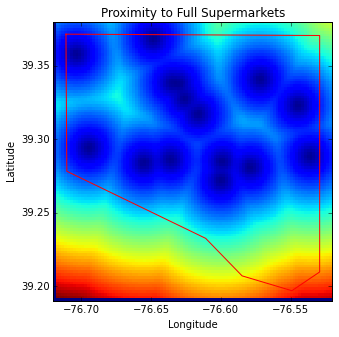

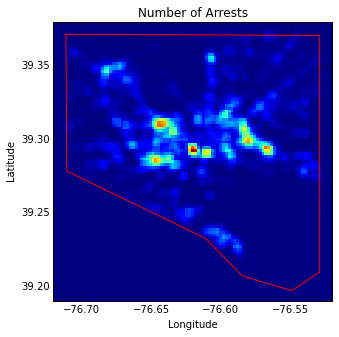

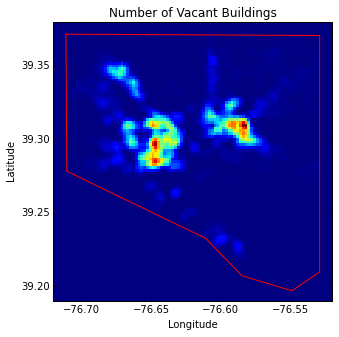

In [6]:
# plot each of the 2D heatmaps from above
#mapcalc.plot_distances_to_POIs(JHU_heat)
#plt.title('Proximity to JHU Homewood')
mapcalc.plot_distances_to_POIs(grocery_heat)
plt.title('Proximity to Full Supermarkets')
mapcalc.plot_distances_to_POIs(arrest_heat)
plt.title('Number of Arrests')
mapcalc.plot_distances_to_POIs(vacancy_heat)
plt.title('Number of Vacant Buildings')

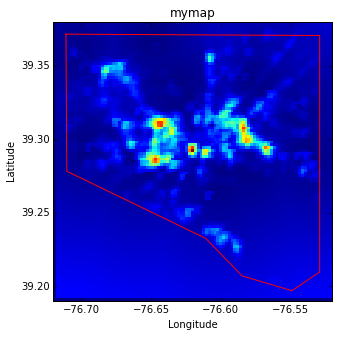

In [62]:
def normalize_map(H):
    return H / float(np.argmax(H)) + 1


#find the best locations by computign the product of the heatmaps above (pairwise)
optimal_locations = ((5.0*normalize_map(grocery_heat)+
                      (normalize_map(vacancy_heat))+
                      (normalize_map(arrest_heat))))
# plot the best locations (hotter is better)
mapcalc.plot_distances_to_POIs(optimal_locations);
plt.title('mymap')

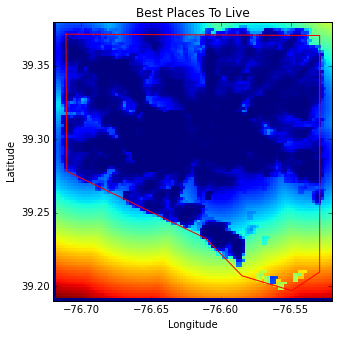

In [11]:
#lowest_val = np.amin(1.0/optimal_locations)
#opt_lat, opt_lon = np.argwhere(1.0/optimal_locations == lowest_val)[0]
#print 'The latitude and longitude coordinates of the best location are:\n%f, %f' % (mapcalc.y[opt_lat], mapcalc.x[opt_lon])

In [8]:
# Wow! That's really close to my house!

In [12]:
optimal_locations

array([[         inf,          inf,          inf, ...,          inf,
                 inf,          inf],
       [         inf,  11.60229411,  11.64030491, ...,  12.287542  ,
         12.25573283,          inf],
       [         inf,  11.77828571,  11.81843379, ...,  12.49262759,
         12.4588838 ,          inf],
       ..., 
       [         inf,  46.07089968,  48.33946934, ...,  19.31742571,
         19.08151942,          inf],
       [         inf,  43.1987089 ,  45.03399683, ...,  18.79979971,
         18.58416431,          inf],
       [         inf,          inf,          inf, ...,          inf,
                 inf,          inf]])

In [28]:
arrest_heat.shape

(100, 100)

In [29]:
edge_size = len(arrest_heat[:,0])
arrest_heat_smooth = np.zeros((edge_size,edge_size))
for i in range(1,edge_size-1):
    for j in range(1,edge_size-1):
        arrest_heat_smooth[i,j] = np.mean(
            (arrest_heat[i,j],
            arrest_heat[i-1,j],
            arrest_heat[i-1,j-1],
            arrest_heat[i+1,j],
            arrest_heat[i-1,j+1],
            arrest_heat[i,j+1],
            arrest_heat[i+1,j+1])
        )

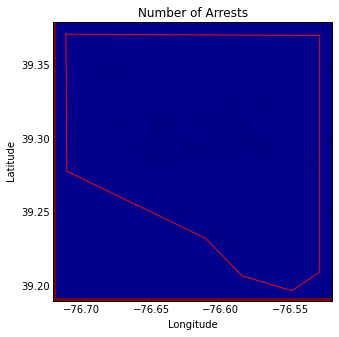

In [32]:
mapcalc.plot_distances_to_POIs(1.0/(arrest_heat_smooth+1))
plt.title('Number of Arrests')

In [8]:
from scipy.stats import gaussian_kde

In [45]:
arrests_kde = gaussian_kde((arrests['Longitude'], arrests['Latitude']))

In [46]:
lon1, lon2 = min(arrests['Longitude']), max(arrests['Longitude'])
lat1, lat2 = min(arrests['Latitude']), max(arrests['Latitude'])

In [83]:
lons = np.linspace(lon1, lon2, 30)
lats = np.linspace(lat1, lat2, 30)
X, Y = np.meshgrid(lons, lats)
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(arrests_kde(positions), X.shape)

[-76.711320248700005,
 -76.529220274499991,
 39.200405984200003,
 39.372934421300002]

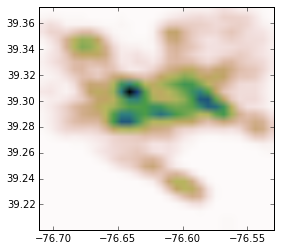

In [85]:
#plt.plot(arrests['Longitude'], arrests['Latitude'], 'k.', markersize=1, alpha=0.1)
plt.imshow(np.rot90(Z.T), cmap=plt.cm.gist_earth_r, extent=[lon1, lon2, lat1, lat2])
plt.axis([lon1, lon2, lat1, lat2])

In [106]:
# Boundary conditions for all maps (longitudes as x vals, latitudes as y vals)
lonmin = -76.72
lonmax = -76.52
latmin = 39.19
latmax = 39.38

# number of points along each map edge
# (total number of points is npts**2)
npts = 30

x = np.linspace(lonmin, lonmax, npts)
y = np.linspace(latmin, latmax, npts)

def kde_map(POIs, plot=True):
    """
    Produces a npts x npts histogram from an array of longitudes and latitudes.

    :param POIs:
        2xn NumPy array of locations
        -or-
        Pandas dataframe containing 'Longitude' and 'Latitude' columns
    :param plot:
        Boolean - if True, produces a plot of the resulting histogram
    :param masked:
        Boolean - if True, returns a masked array (zeros are masked)
    :return:
        npts x npts NumPy array (2D histogram)
    """
    # get POI's
    try:
        # if coordinates as arrays
        lons, lats = POIs[:, 1], POIs[:, 0]
    except TypeError:
        # if coordinates in pandas dataframe
        lons, lats = POIs['Longitude'].values, POIs['Latitude'].values

    maprange = np.array([(lonmin, lonmax), (latmin, latmax)])

    kernel = gaussian_kde((lons, lats))

    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions), X.shape)

    # correct orientation of kernel density estimate
    Z = np.rot90(Z.T)

    if plot:
        # Plot KDE
        plt.figure(figsize=(6, 5))
        plt.plot(lons, lats, 'k.', markersize=1, alpha=1)
        plt.imshow(Z,
                   cmap=plt.cm.gist_earth_r,
                   extent=[lonmin, lonmax, latmin, latmax]
                    )
        plt.axis([lon1, lon2, lat1, lat2])
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        cbar = plt.colorbar()
        cbar.ax.set_ylabel('Kernel Density (arb.)')

    return Z

In [113]:
Z_arrests = kde_map(arrests, False);
Z_schools = kde_map(schools, False);
Z_groceries = kde_map(groceries, False);

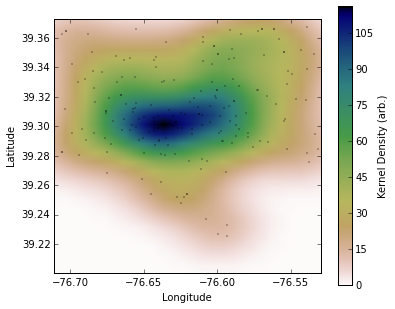

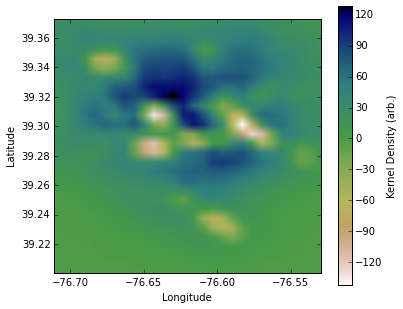

In [114]:
plt.figure(figsize=(6, 5))
#plt.plot(lons, lats, 'k.', markersize=1, alpha=1)
plt.imshow(Z_schools-Z_arrests+Z_groceries,
           cmap=plt.cm.gist_earth_r,
           extent=[lonmin, lonmax, latmin, latmax]
          )
plt.axis([lon1, lon2, lat1, lat2])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Kernel Density (arb.)')